# Image Forgery Detection
By Mohamed Atta

This notebook's goal is to use a pretrained model on the FaceForensics++ dataset with the Deepfakes manipulation only.
This implementation uses PyTorch and was run locally on a device with the following specifications:
- GPU: NVIDIA GTX 1650 (dedicated mem: 4GB, shared mem: 7GB)
- CPU: AMD Ryzen 7
- RAM: 16GB

## Prerequisites
### - Download and setup the FaceForensics++ dataset (shown in the steps below)
#### Step 1:
Open a command terminal and run the `download_FaceForensics.py` file in the utils folder using the following commands:\
`python download_FaceForensics.py -d original -c c40` -> downloads the original videos with the lowest compression quality\
`python download_FaceForensics.py -d Deepfakes -c c40` -> downloads deepfaked videos with the lowest compression quality

#### Step 2:
Run `python extract_compressed_videos.py -d original -c c40` and `python extract_compressed_videos.py -d Deepfakes -c c40`

Now, the data should be in the folder output inside the Real and Fake folders. You are set to run this file now.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
import copy
import numpy as np
import time

# Utilize GPU if available else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading FaceForensics++ dataset

In [2]:
# # Define the transformations to be applied to each iamge
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
# Specify hyper-parameters
batch_size = 128
learning_rate = 0.1
momentum = 0.9
gamma = 0.1
step_size = 3
epochs = 5

In [4]:
# Making train, val, test splits
class FaceForensics(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, index):
        if self.transform:
            img = self.transform(self.dataset[index][0])
        else:
            img = self.dataset[index][0]

        label = self.dataset[index][1]

        return img, label
    
    def __len__(self):
        return len(self.dataset)


# Load the dataset using the ImageFolder function
data_path = './dataset/output'
dataset = ImageFolder(data_path)

train = FaceForensics(dataset, transform)
val = FaceForensics(dataset, transform)
test = FaceForensics(dataset, transform)

In [5]:
# Create index splits
train_size = 0.8

ds_len = len(dataset)
indices = list(range(ds_len))
split = int(np.floor(train_size * ds_len))
split2 = int(np.floor((train_size+(1-train_size)/2) * ds_len))
np.random.shuffle(indices)

train_idx, val_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

# Split dataset
train = Subset(train, indices=train_idx)
val = Subset(val, indices=val_idx)
test = Subset(test, test_idx)

# Create PyTorch dataloaders
trainLoader = DataLoader(train, batch_size=batch_size)
valLoader = DataLoader(val, batch_size=batch_size)
testLoader = DataLoader(test, batch_size=batch_size)

loader = {
    'train' : trainLoader,
    'val'   : valLoader,
    'test'  : testLoader
}

dataset_sizes = {'train': len(train),
                 'val': len(val),
                 'test': len(test)}

## Transfer learning
- Load pretrianed model
- Replace last layer
- Fine-tune

In [43]:
# Load ResNet pretrained on ImageNet
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace FC
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Send model to device
model = model.to(device)

You can skip this cell if you are not training the model

In [7]:
# Fine-tune
def train_model(criterion, optimizer, scheduler, epochs):
    since = time.time()

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)

        # Each epoch has a training & validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over batches
            for images, labels in loader[phase]:
                # Send batch to device
                images, labels = images.to(device), labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Track gradients only in training
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward prop
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward prop
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * images.size(0) # Total batch loss
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step() # decay learning rate
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f}  ||  Acc: {epoch_acc:.4f}')

            # Deep copy the model when getting better accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
                torch.save(best_weights, './weights/tuned_resnet50.pth')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_weights)
    return model, (train_losses, train_accs, val_losses, val_accs)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Decay LR by a factor of 0.1 every epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train model
model, graphing = train_model(criterion, optimizer, scheduler, epochs)

Epoch 1/5
----------
train Loss: 0.4128  ||  Acc: 0.8332
val Loss: 0.2406  ||  Acc: 0.9091
Epoch 2/5
----------
train Loss: 0.1190  ||  Acc: 0.9845
val Loss: 0.0924  ||  Acc: 0.9862
Epoch 3/5
----------
train Loss: 0.0727  ||  Acc: 0.9945
val Loss: 0.0645  ||  Acc: 0.9917
Epoch 4/5
----------
train Loss: 0.0592  ||  Acc: 0.9969
val Loss: 0.0617  ||  Acc: 0.9945
Epoch 5/5
----------
train Loss: 0.0576  ||  Acc: 0.9976
val Loss: 0.0603  ||  Acc: 0.9945
Training complete in 9m 28s
Best val Acc: 0.994490


Skip this cell if you are not training the model

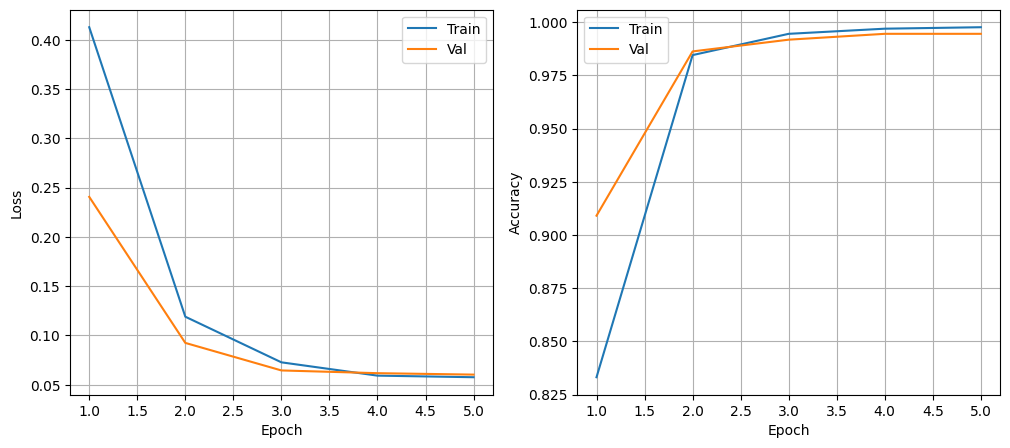

In [30]:
# Training visualization
def plt_training(values):
    import matplotlib.pyplot as plt
    # plt.grid()
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    ax[0].plot(torch.arange(1,6), torch.Tensor(values[0]), label='Train')
    ax[0].plot(torch.arange(1,6), torch.Tensor(values[2]), label='Val')
    ax[0].grid()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(torch.arange(1,6), torch.Tensor(values[1]), label='Train')
    ax[1].plot(torch.arange(1,6), torch.Tensor(values[3]), label='Val')
    ax[1].grid()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.show()

plt_training(graphing)

In [73]:
# Load tuned model
model.load_state_dict(torch.load('./weights/tuned_resnet50.pth'))

<All keys matched successfully>

In [51]:
def test_model(model):
    model.eval()
    
    total_loss = 0.0
    corrects = 0

    with torch.inference_mode():
        for images, labels in loader['test']:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            corrects += torch.sum(preds == labels.data)
        
        total_loss /= dataset_sizes['test']
        acc = corrects / dataset_sizes['test']
    
    print('Testing complete.')
    print(f'Loss: {total_loss}  ||  Acc: {acc}')

test_model(model)

Testing complete.
Loss: 0.06465784831808946  ||  Acc: 0.991735577583313


In [82]:
from PIL import Image

def predict(image):
    # Preprocess
    image = transform(Image.fromarray(image))

    # Model prediction
    model.to('cpu')
    output = model(torch.unsqueeze(image,0))
    
    # Cast to desired
    _, prediction = torch.max(output, 1)    # argmax

    # Prediction mapping
    mapping = {0: 'Fake', 1: 'Authentic'}

    return mapping[int(prediction.item())]

## Model deployment
Using Gradio for model deployment API

In [83]:
import gradio as gr

api = gr.Interface(
    fn=predict, 
    inputs=gr.Image(shape=(224, 224),label="Upload an Image"), 
    outputs=gr.Textbox(label="Predicted Class"), 
    title="Image Forgery Detection System",
    description= "This system checks whether an image was deepfaked. Input an image to be checked."
)

api.launch(share=True)

Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


## References
- https://github.com/ondyari/FaceForensics
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://discuss.pytorch.org/t/using-imagefolder-random-split-with-multiple-transforms/79899/4
- https://ravimashru.dev/blog/2021-09-26-pytorch-subset/